In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ratings_Electronics.csv', header=None)  # There are no headers in the data file
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']  # Adding column names
df = df.drop('timestamp', axis=1)  # Dropping timestamp
df_copy = df.copy(deep=True)  # Copying the data to another DataFrame
df.head()  # Showing the first rows of the dataset

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


# EDA ANALYSIS

Shape

In [3]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  7824482
No of columns =  3


Datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


Missing Values

In [5]:
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

Summary statistics of 'rating' variable

In [6]:
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Distribution of "rating"

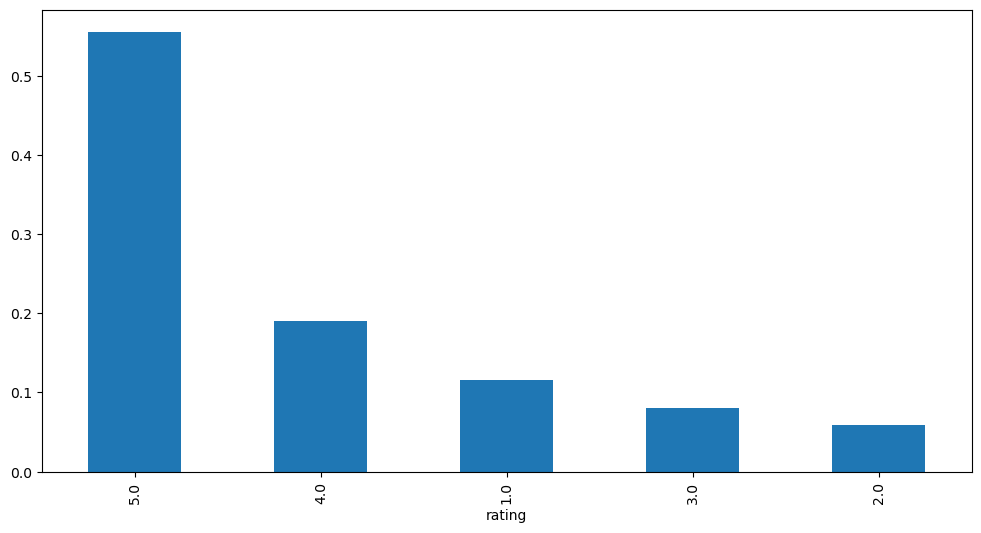

In [9]:
# Plot of ratings column
plt.figure(figsize=(12, 6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

Over 50% of the ratings are 5
Around 20% with 4 star ratings
Below 10% of the ratings are 2 stars.
The distribution is right-skewed

In [10]:
# Number of unique user id and product id in the data
print('Number of unique users in Raw data = ', df['user_id'].nunique())
print('Number of unique items in Raw data = ', df['prod_id'].nunique())

Number of unique users in Raw data =  4201696
Number of unique items in Raw data =  476002


In [11]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

Pre-Processing

In [12]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]  # Users who have rated 50 or more items
print('The number of observations in the final data =', len(df_final))
print('Number of unique users in the final data = ', df_final['user_id'].nunique())
print('Number of unique products in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique users in the final data =  1540
Number of unique products in the final data =  48190


In [16]:
import warnings
warnings.filterwarnings('ignore')
# Check for non-numeric values in the 'rating' column
non_numeric_ratings = df_final[pd.to_numeric(df_final['rating'], errors='coerce').isna()]
print(non_numeric_ratings)

# Convert 'rating' to numeric, forcing non-numeric entries to NaN
df_final['rating'] = pd.to_numeric(df_final['rating'], errors='coerce')

# Drop rows with NaN values in 'rating'
df_final = df_final.dropna(subset=['rating'])

# Ensure 'rating' is integer
df_final['rating'] = df_final['rating'].astype(int)

# Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index='user_id', columns='prod_id', values='rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

# Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given num.of ratings = ', given_num_of_ratings)

# Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible num.of ratings = ', possible_num_of_ratings)

# Density of ratings
density = (given_num_of_ratings / possible_num_of_ratings) * 100
print('density: {:4.2f}%'.format(density))

Empty DataFrame
Columns: [user_id, prod_id, rating]
Index: []
Shape of final_ratings_matrix:  (1540, 48190)
given num.of ratings =  125871
possible num.of ratings =  74212600
density: 0.17%


# Rank-based Recommendation System

In [17]:
# Rank-based Recommendation System
average_rating = df_final.groupby('prod_id')['rating'].mean()  # Calculate the average rating for each product
count_rating = df_final.groupby('prod_id')['rating'].count()  # Calculate the count of ratings for each product

final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})  # Create a DataFrame with the calculated average and count of ratings
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)  # Sort the DataFrame by average ratings
print(final_rating.head())  # Display the top entries


            avg_rating  rating_count
prod_id                             
0594451647         5.0             1
B003RRY9RS         5.0             1
B003RR95Q8         5.0             1
B003RIPMZU         5.0             1
B003RFRNYQ         5.0             2


In [18]:
 #defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]

***Recommending top 5 products with 50 minimum interactions based on popularity***

In [21]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

***Recommending top 5 products with 100 minimum interactions based on popularity***

In [22]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

# Collaborative Filtering based Recommendation System

***User based collaborative filtering***

In [23]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Function to find Similar users and their similarity scores**

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds # for sparse matrices

In [26]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

***Finding out top 10 similar users to the user index 3 and their similarity score***

In [27]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [28]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

***Finding out top 10 similar users to the user index 1521 and their similarity score***

In [29]:
#Finding out top 10 similar users to the user index 1521 and their similarity score
similar = similar_users(1521, final_ratings_matrix)[0][0:10]
similar

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [30]:
#Print the similarity score
similar_users(1521,final_ratings_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

***Function to recommend products***

In [31]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

***Recommend 5 products to user index 3 based on similarity based collaborative filtering***

In [32]:
recommendations(3,5,final_ratings_matrix)

['B001TAAVP4', 'B0058FYLC0', 'B0015ZIS8K', 'B00011KHVA', 'B005K7192G']

***Recommend 5 products to user index 1521 based on similarity based collaborative filtering***

In [33]:
recommendations(1521,5,final_ratings_matrix)

['B00G4FCKB2', 'B004SNCZ3K', 'B003YBUSMW', 'B005LIDN14', 'B005LIDMYM']

# Model based Collaborative Filtering: Singular Value Decompositionatrix

We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition.Also, we will use k=50 latent features to predict rating of products

**CSR matrix**

In [34]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

**SVD**

In [35]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [36]:
U.shape

(1540, 50)

In [37]:
sigma.shape

(50, 50)

In [38]:
Vt.shape

(50, 48190)

Predicting ratings

In [39]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

**Function to recommend products**

In [40]:
def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

***Recommending top 10 products to user id 50***

In [41]:
recommend_items(50,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 50):

Recommended Products
15538    0.340253
10276    0.326917
21982    0.276580
22210    0.252595
18891    0.230495
10182    0.223545
28761    0.221229
38250    0.220487
39003    0.198833
1061     0.198304
Name: user_predictions, dtype: float64


***Recommending top 5 products to user id 75***

In [42]:
recommend_items(75,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 75):

Recommended Products
38656    2.062606
22210    1.484572
47142    1.422576
23378    1.419281
25554    1.140246
Name: user_predictions, dtype: float64


**Evaluating the model**

In [44]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)
# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [46]:
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


In [47]:
avg_preds=preds_df.mean()
avg_preds.head()

prod_id
0594451647    0.003360
0594481813    0.005729
0970407998    0.008566
0972683275    0.035330
1400501466    0.006966
dtype: float64

In [48]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


In [49]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.013679389779857998 

